In [6]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pandas_market_calendars as mcal
from sklearn.decomposition import PCA

## 1. Data Exploration

In [4]:
base_path = './stock-market/Data/Stocks'
paths = []

for file in glob.glob(base_path + '/*.txt'):
    paths.append(file)

In [7]:
df_list = []
empty_file_symbols = []

count = 0
for path in paths:
    count += 1
    symbol = path.split('/')[-1].split('.')[0]

    # Attempt to read the stock data
    try:
        stock_df = pd.read_csv(path)
        stock_df['Symbol'] = symbol
        df_list.append(stock_df)

    # Ignore empty or unreadable files
    except:
        empty_file_symbols.append(symbol)

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Symbol'] = df['Symbol'].astype('string')

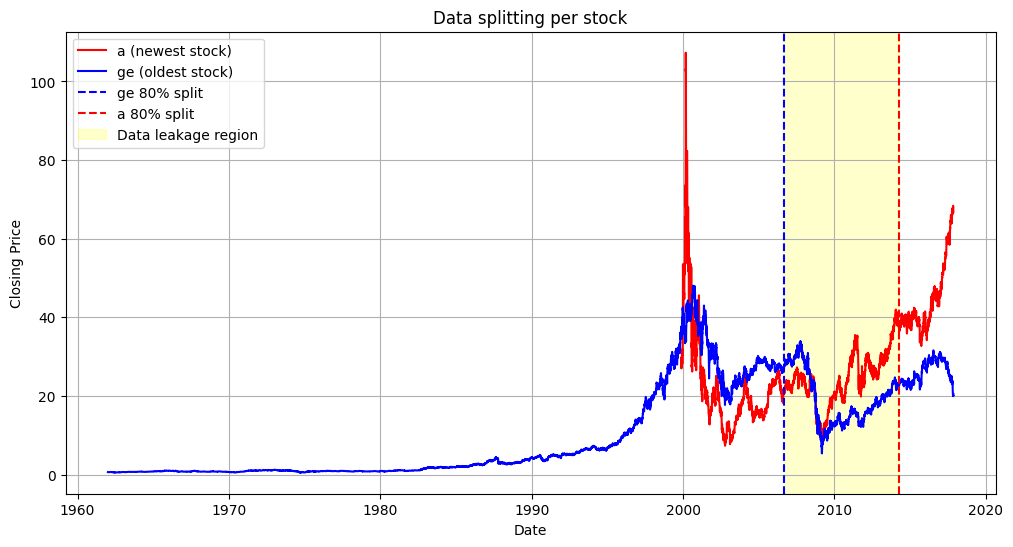

In [12]:
# show stock data plot for the symbol with the oldest data
oldest_symbol = df.groupby('Symbol')['Date'].min().idxmin()
oldest_symbol_df = df[df['Symbol'] == oldest_symbol]

newest_symbol = df.groupby('Symbol')['Date'].max().idxmax()
newest_symbol_df = df[df['Symbol'] == newest_symbol]

# --- compute per-stock 80% split dates ---
oldest_start = oldest_symbol_df['Date'].min()
oldest_end   = oldest_symbol_df['Date'].max()
oldest_split = oldest_start + 0.8 * (oldest_end - oldest_start)

newest_start = newest_symbol_df['Date'].min()
newest_end   = newest_symbol_df['Date'].max()
newest_split = newest_start + 0.8 * (newest_end - newest_start)

plt.figure(figsize=(12, 6))
plt.title('Data splitting per stock')

# price curves
plt.plot(newest_symbol_df['Date'], newest_symbol_df['Close'],
         label=newest_symbol + " (newest stock)", color='red')
plt.plot(oldest_symbol_df['Date'], oldest_symbol_df['Close'],
         label=oldest_symbol + " (oldest stock)", color='blue')

# 80/20 per-stock split lines
plt.axvline(oldest_split, linestyle='--', color='blue',
            label=f'{oldest_symbol} 80% split')
plt.axvline(newest_split, linestyle='--', color='red',
            label=f'{newest_symbol} 80% split')

# --- shaded data-leakage region: between the two split dates ---
leak_start = min(oldest_split, newest_split)
leak_end   = max(oldest_split, newest_split)
plt.axvspan(leak_start, leak_end, alpha=0.2, color='yellow',
            label='Data leakage region')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid()

plt.legend()
plt.show()


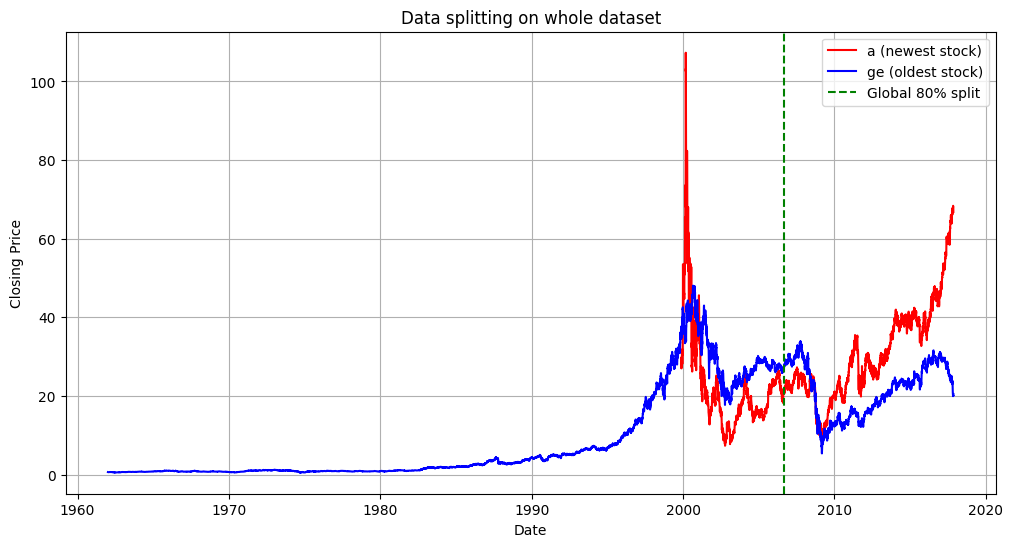

In [13]:
# --- existing code for oldest/newest symbols (unchanged) ---
oldest_symbol = df.groupby('Symbol')['Date'].min().idxmin()
oldest_symbol_df = df[df['Symbol'] == oldest_symbol]

newest_symbol = df.groupby('Symbol')['Date'].max().idxmax()
newest_symbol_df = df[df['Symbol'] == newest_symbol]

# --- global 80/20 split over the whole dataset ---
global_start = df['Date'].min()
global_end = df['Date'].max()
global_split = global_start + 0.8 * (global_end - global_start)

plt.figure(figsize=(12, 6))
plt.title('Data splitting on whole dataset')

# price curves for oldest & newest stock (just for illustration)
plt.plot(newest_symbol_df['Date'], newest_symbol_df['Close'],
         label=newest_symbol + " (newest stock)", color='red')
plt.plot(oldest_symbol_df['Date'], oldest_symbol_df['Close'],
         label=oldest_symbol + " (oldest stock)", color='blue')

# single global split line
plt.axvline(global_split, linestyle='--', label='Global 80% split', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid()
plt.legend()
plt.show()

a. Explore the dataset by displaying the first few rows, summary statistics, and data types of each column.

In [5]:
# Display first few rows
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Symbol
0,2005-02-25,12.868,12.982,12.834,12.834,15928,0,iba
1,2005-02-28,13.536,13.536,13.273,13.281,16382,0,iba
2,2005-03-01,13.185,13.299,13.185,13.299,1250,0,iba
3,2005-03-02,13.361,13.395,13.273,13.291,8760,0,iba
4,2005-03-03,13.361,13.404,12.966,13.218,9897,0,iba


In [6]:
# print unique symbols in df
print(f"Unique symbols in dataframe: {df['Symbol'].nunique()}")

Unique symbols in dataframe: 7163


In [7]:
# find out if some df frames with unique symbols have some duplicate data, i.e a company with multiple entries for the same date
duplicate_entries = df.duplicated(subset=['Symbol', 'Date'], keep=False)
duplicate_symbols = df[duplicate_entries]['Symbol'].unique()
print(f"Symbols with duplicate entries: {duplicate_symbols}")

Symbols with duplicate entries: <StringArray>
[]
Length: 0, dtype: string


In [8]:
# Summarize statistics
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,Date,Open,High,Low,Close,Volume,OpenInt
count,14887665,14887665.00,14887665.00,14887665.00,14887665.00,14887665.00,14887665.00
mean,2010-06-19 22:22:30.382936576,30385.38,31212.47,29361.76,30245.22,1585730.32,0.00
min,1962-01-02 00:00:00,0.00,0.00,-1.00,0.00,0.00,0.00
25%,2007-11-29 00:00:00,7.75,7.88,7.61,7.75,32800.00,0.00
50%,2012-02-17 00:00:00,15.68,15.92,15.43,15.68,192266.00,0.00
75%,2015-05-21 00:00:00,28.90,29.28,28.50,28.90,891786.00,0.00
max,2017-11-10 00:00:00,1423712891.00,1442048636.45,1362117843.98,1437986240.44,2423735131.00,0.00
std,NaN,4202500.95,4323485.55,4046981.00,4180590.07,7635186.71,0.00


In [9]:
# Data types for each column
df.dtypes.to_frame(name='dtype').rename_axis('column').reset_index()

,column,dtype
0,Date,datetime64[ns]
1,Open,float64
2,High,float64
3,Low,float64
4,Close,float64
5,Volume,int64
6,OpenInt,int64
7,Symbol,string[python]


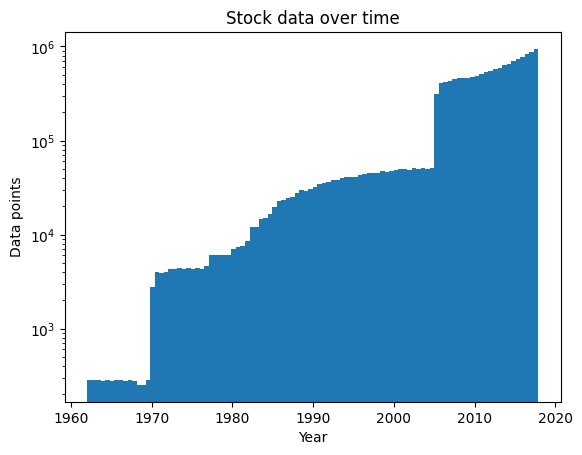

In [10]:
# Number of stock data rows over time
plt.hist(data=df, x='Date', bins=100)
plt.title('Stock data over time')
plt.xlabel('Year')
plt.yscale('log')
plt.ylabel('Data points')
plt.show()

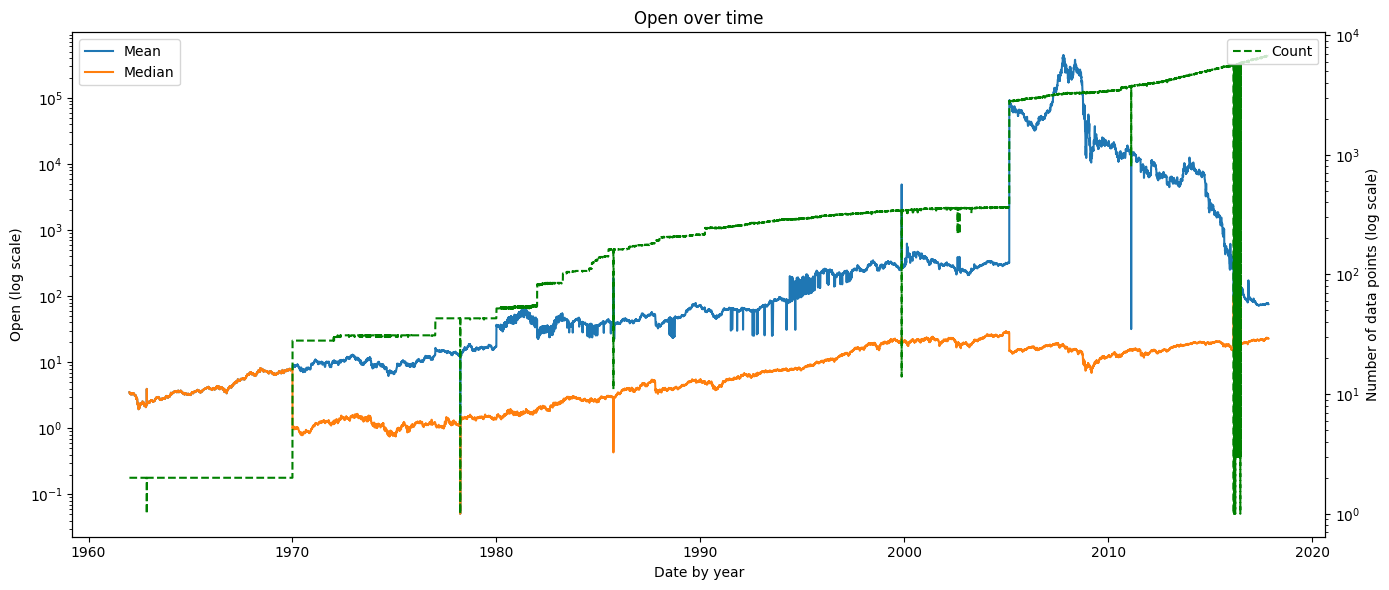

In [11]:
# Mean and median value for columns over time before forward-filling
date_data = df.groupby('Date')
dates = list(date_data.indices.keys())

columns = ['Open'] # columns = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in columns:
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(dates, date_data[col].mean(), label="Mean")
    ax1.plot(dates, date_data[col].median(), label="Median")
    ax1.set_xlabel('Date by year')
    ax1.set_ylabel(f'{col} (log scale)')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(dates, date_data[col].count(), label='Count', color='green',  linestyle='--')
    ax2.set_ylabel('Number of data points (log scale)')
    ax2.set_yscale("log")
    ax2.legend(loc='upper right')

    plt.title(f'{col} over time')
    plt.tight_layout()
    plt.show()

b. Identify missing values, outliers, and unique values in categorical columns.

In [12]:
# Missing values per column
df.isna().sum().to_frame('missing_values').rename_axis('column').reset_index()

,column,missing_values
0,Date,0
1,Open,0
2,High,0
3,Low,0
4,Close,0
5,Volume,0
6,OpenInt,0
7,Symbol,0


In [13]:
# Number of companies with no stock data
print("Number of companies (symbols) without data:", len(empty_file_symbols))
print("Number of companies (symbols) with data:", df["Symbol"].nunique())

Number of companies (symbols) without data: 32
Number of companies (symbols) with data: 7163


/Users/jakobnordlundby/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)


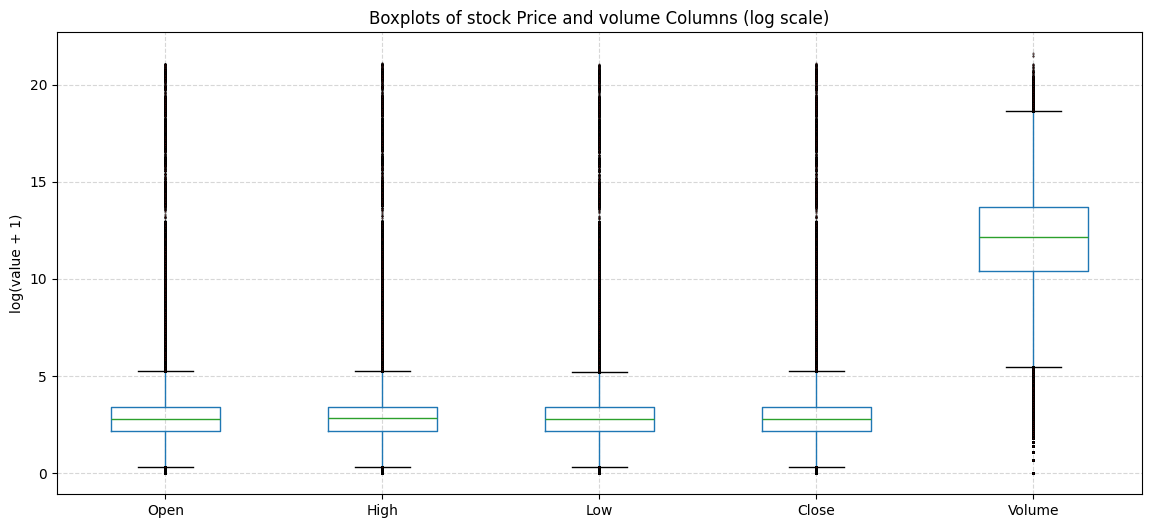

In [14]:
# Outliners with boxplot
columns = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(14, 6))

# Customize outlier appearance with flierprops
flierprops = dict(marker='o', markersize=0.5, markerfacecolor='red', linestyle='none', alpha=0.6)

np.log1p(df[columns]).boxplot(flierprops=flierprops) 
plt.title("Boxplots of stock Price and volume Columns (log scale)")
plt.ylabel("log(value + 1)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [15]:
# Unique values per column
display(df.nunique().to_frame('unique_values').rename_axis('column').reset_index())

,column,unique_values
0,Date,14084
1,Open,302386
2,High,329250
3,Low,329416
4,Close,306846
5,Volume,3478581
6,OpenInt,1
7,Symbol,7163


## 2. Data Cleaning

a. Handling Missing Values

b. Choose appropriate methods to handle missing values (e.g., mean/median
imputation for numerical data, mode imputation for categorical data, or deletion of
rows/columns).

In [16]:
# Drop OpenInt column
print('Number of unique values in OpenInt column:', df['OpenInt'].nunique())
df = df.drop(columns=['OpenInt'])
df.head()

Number of unique values in OpenInt column: 1


,Date,Open,High,Low,Close,Volume,Symbol
0,2005-02-25,12.87,12.98,12.83,12.83,15928,iba
1,2005-02-28,13.54,13.54,13.27,13.28,16382,iba
2,2005-03-01,13.19,13.30,13.19,13.30,1250,iba
3,2005-03-02,13.36,13.39,13.27,13.29,8760,iba
4,2005-03-03,13.36,13.40,12.97,13.22,9897,iba


In [17]:
# print number of unique days in the dataset
print(f"Unique days in dataframe: {df['Date'].nunique()}")

Unique days in dataframe: 14084


In [18]:
date_col = "Date"
symbol_col = "Symbol"

temp_df = df.copy()

nyse = mcal.get_calendar("NYSE")

total_missing_dates = 0                     
unique_missing_dates = set()               
companies_with_missing = []
missing_stats = []

for symbol, group in temp_df.groupby(symbol_col, sort=False):
    group = group.sort_values(date_col)
    start = group[date_col].min()
    end = group[date_col].max()

    # NYSE valid trading days for this period
    schedule = nyse.schedule(start_date=start, end_date=end)
    expected_days = schedule.index.normalize()

    actual_days = pd.DatetimeIndex(group[date_col].dt.normalize().unique())
    missing_days = expected_days.difference(actual_days)

    n_missing = len(missing_days)
    if n_missing > 0:
        # 1) total, including duplicates across companies
        total_missing_dates += n_missing

        # 2) unique across all companies
        unique_missing_dates.update(missing_days)

        companies_with_missing.append(symbol)
        missing_stats.append({
            "Symbol": symbol,
            "missing_trading_days": n_missing,
            "from": start,
            "to": end,
        })

In [19]:
metrics_df = pd.DataFrame(
    {
        "Value": [
            len(df),
            len(df["Date"].unique()),
            total_missing_dates,
            len(unique_missing_dates),
            len(set(companies_with_missing)),
            (total_missing_dates / (len(df) + total_missing_dates)) * 100,
            (len(unique_missing_dates) / (len(df["Date"].unique()) + len(unique_missing_dates))) * 100,
            (len(set(companies_with_missing)) / df["Symbol"].nunique()) * 100,
        ]
    },
    index=[
        "Trading days",
        "Unique trading days",
        "Missing trading days",
        "Unique missing trading days",
        "Companies with missing trading days",
        "Percentage of missing trading days",
        "Percentage of unique missing trading days",
        "Percentage of companies with missing trading days",
    ],
)

metrics_df = metrics_df.reset_index().rename(columns={"index": "Metric"})

styled = (
    metrics_df.style
    .hide(axis="index")  
    .format("{:,.0f}", subset=(metrics_df.index[:5], ["Value"]))
    .format("{:.2f}%", subset=(metrics_df.index[5:], ["Value"]))
)

styled

Metric,Value
Trading days,"14,887,665"
Unique trading days,"14,084"
Missing trading days,"372,274"
Unique missing trading days,"6,913"
Companies with missing trading days,"5,186"
Percentage of missing trading days,2.44%
Percentage of unique missing trading days,32.92%
Percentage of companies with missing trading days,72.40%


In [20]:
date_col = "Date"
symbol_col = "Symbol"

df_filled = df.copy()

# NYSE calendar to avoid flagging weekends/holidays
nyse = mcal.get_calendar("NYSE")

filled_data = []
symbol_stats = []

for symbol, group in df_filled.groupby(symbol_col, sort=False):
    group = group.sort_values(date_col)
    start = group[date_col].min()
    end = group[date_col].max()

    # NYSE trading days for this symbol's period (make naive)
    schedule = nyse.schedule(start_date=start, end_date=end)
    expected_days = schedule.index.tz_localize(None)

    # reindex to NYSE days
    group = group.set_index(date_col)
    group_reindexed = group.reindex(expected_days)

    # mark which rows are newly created (i.e. missing in source)
    is_new = group_reindexed.index.difference(group.index)
    group_reindexed["_is_new"] = False
    group_reindexed.loc[is_new, "_is_new"] = True

    # fill symbol and forward-fill values
    group_reindexed[symbol_col] = symbol
    value_cols = [c for c in temp_df.columns if c not in (date_col, symbol_col)]
    group_reindexed[value_cols] = group_reindexed[value_cols].ffill()

    # compute stats
    filled_rows = int(group_reindexed["_is_new"].sum())
    total_rows = int(len(group_reindexed))
    first_date = group_reindexed.index.min()
    last_date = group_reindexed.index.max()
    years_of_history = (last_date - first_date).days / 365.25

    # longest missing streak
    longest = 0
    curr = 0
    for flag in group_reindexed["_is_new"].tolist():
        if flag:
            curr += 1
            longest = max(longest, curr)
        else:
            curr = 0

    symbol_stats.append({
        "Symbol": symbol,
        "forward_filled_rows": filled_rows,
        "total_rows": total_rows,
        "ff_share": filled_rows / total_rows if total_rows else 0,
        "longest_missing_streak": int(longest),
        "first_date": first_date,
        "last_date": last_date,
        "years_of_history": years_of_history,
    })

    # restore date column
    group_reindexed.index.name = date_col
    filled_data.append(group_reindexed.reset_index())

# combined filled df
df_filled = (
    pd.concat(filled_data, ignore_index=True)
      .sort_values([symbol_col, date_col], kind="mergesort")
)

In [21]:
print(len(df["Date"].unique()))
print(len(df_filled["Date"].unique()))

14084
14064


In [22]:
metrics_df = pd.DataFrame(
    {
        "Value": [
            len(df),
            len(df_filled),
            len(df_filled) - len(df),
            (len(df_filled) - len(df)) / len(df_filled) * 100,
        ]
    },
    index=[
        "Number of trading days before forward-filling",
        "Number of trading days after forward-filling",
        "Number of forward-filled trading days",
        "Percentage of forward-filled trading days",
    ],
)

metrics_df = metrics_df.reset_index().rename(columns={"index": "Metric"})

styled = (
    metrics_df.style
    .hide(axis="index")
    .format("{:,.0f}", subset=(metrics_df.index[:3], ["Value"]))
    .format("{:.2f}%", subset=(metrics_df.index[3:], ["Value"]))
)
styled

Metric,Value
Number of trading days before forward-filling,"14,887,665"
Number of trading days after forward-filling,"15,259,882"
Number of forward-filled trading days,"372,217"
Percentage of forward-filled trading days,2.44%


In [23]:
value_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_filled[value_cols].describe()

,Open,High,Low,Close,Volume
count,15259882.00,15259882.00,15259882.00,15259882.00,15259882.00
mean,29654.16,30461.31,28655.26,29517.39,1547719.76
std,4150959.72,4270459.36,3997348.37,4129317.16,7546368.41
min,0.00,0.00,-1.00,0.00,0.00
25%,7.68,7.81,7.54,7.68,27848.00
50%,15.60,15.83,15.35,15.60,178585.00
75%,28.69,29.06,28.30,28.69,854989.00
max,1423712891.00,1442048636.45,1362117843.98,1437986240.44,2423735131.00


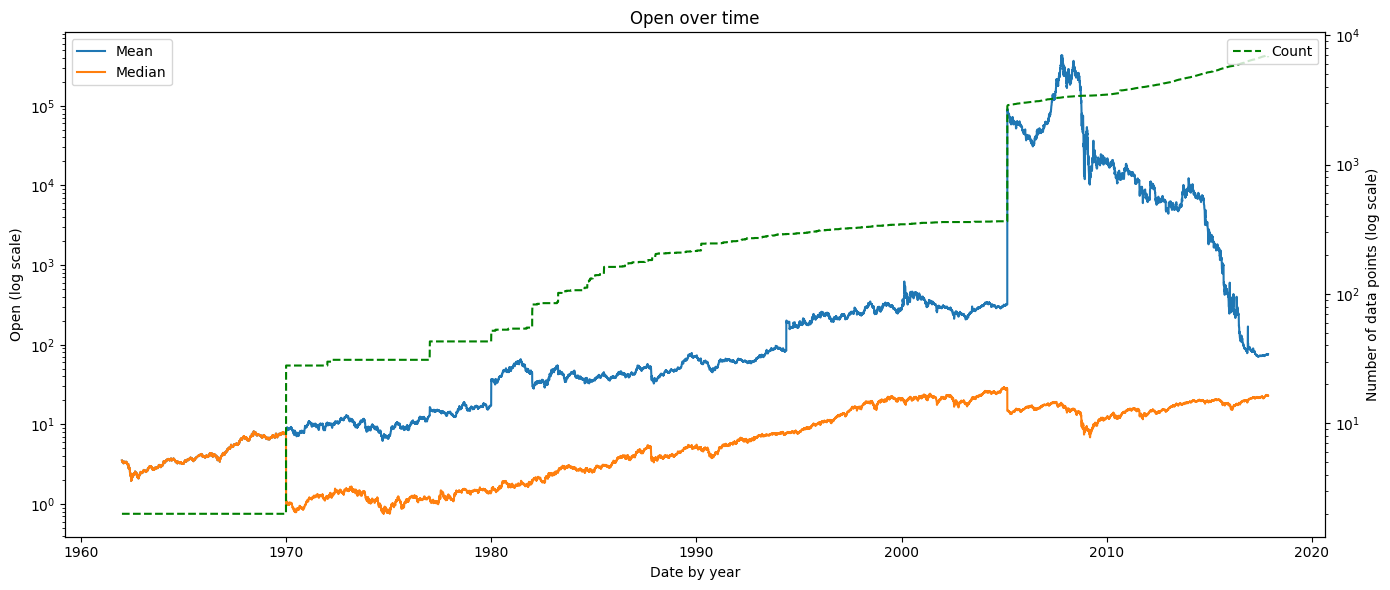

In [24]:
date_data = df_filled.groupby('Date')
dates = list(date_data.indices.keys())

columns = ['Open'] # ['Open', 'High', 'Low', 'Close', 'Volume']

for col in columns:
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(dates, date_data[col].mean(), label="Mean")
    ax1.plot(dates, date_data[col].median(), label="Median")
    ax1.set_xlabel('Date by year')
    ax1.set_ylabel(f'{col} (log scale)')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(dates, date_data[col].count(), label='Count', color='green',  linestyle='--')
    ax2.set_ylabel('Number of data points (log scale)')
    ax2.set_yscale("log")
    ax2.legend(loc='upper right')

    plt.title(f'{col} over time')
    plt.tight_layout()
    plt.show()

In [25]:
df = df_filled.copy()

c. Justify your choices for handling missing data

## 3. Handling outliers

a. Detect outliers using methods such as the IQR method or Z-score.

In [26]:
# Outlier detection using rolling z-score method and imputation with forward-fill
value_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

window = 15
minp = 2
threshold = 3
eps = 1e-8

df_clean = df.copy().sort_values(['Symbol', 'Date'])

rolling_mean = (
    df_clean.groupby("Symbol")[value_cols]
            .transform(lambda x: x.rolling(window, min_periods=minp, center=True).mean())
)
rolling_std = (
    df_clean.groupby("Symbol")[value_cols]
            .transform(lambda x: x.rolling(window, min_periods=minp, center=True).std())
)

rolling_z = (df_clean[value_cols] - rolling_mean) / (rolling_std + eps)

outlier_mask = (rolling_z.abs() > threshold) & rolling_std.notna()
negative_mask = df_clean[value_cols] < 0

mask = outlier_mask | negative_mask

rows_flagged = int(mask.any(axis=1).sum())

df_clean[value_cols] = df_clean[value_cols].mask(mask)

df_clean[value_cols] = (
    df_clean.groupby("Symbol")[value_cols]
            .ffill()
            .bfill()
)

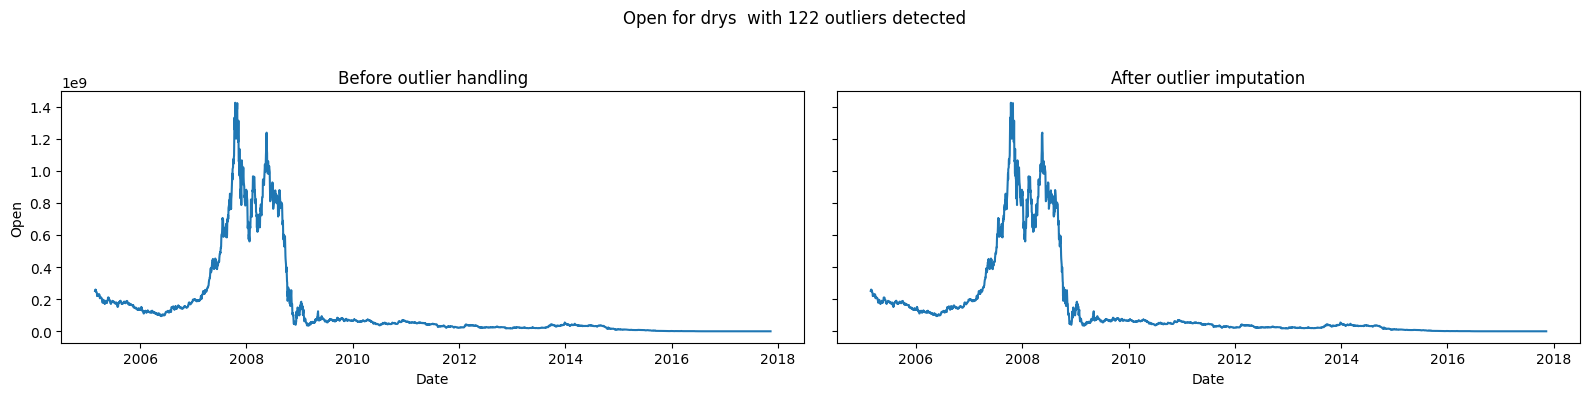

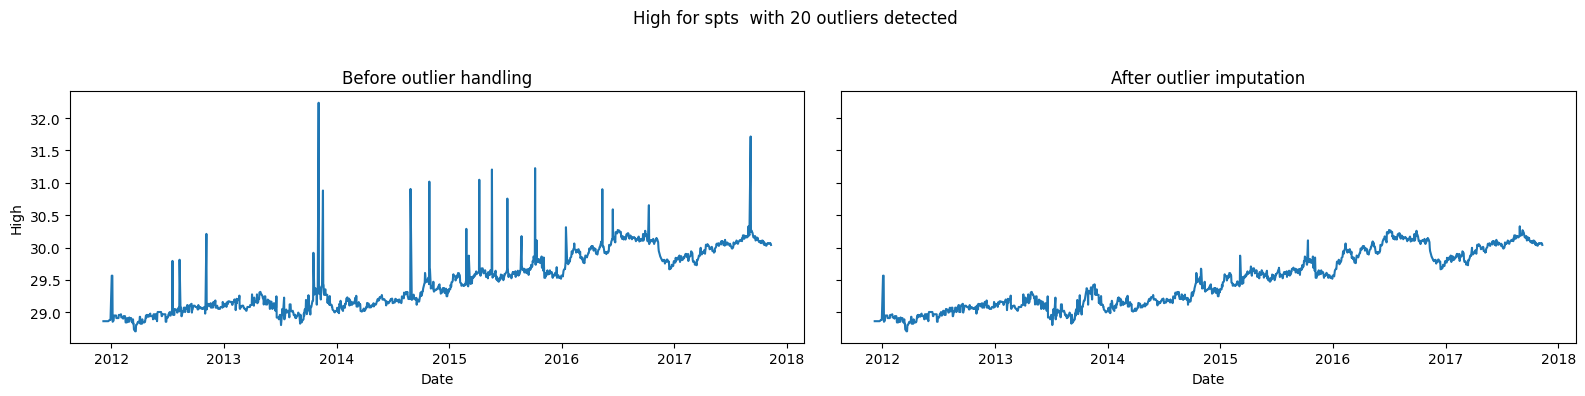

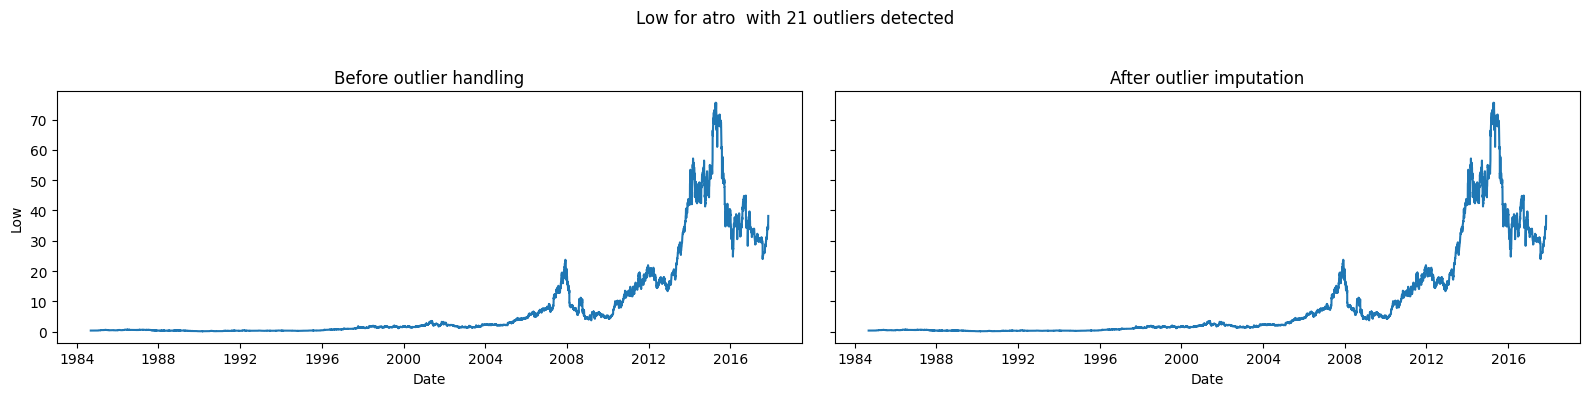

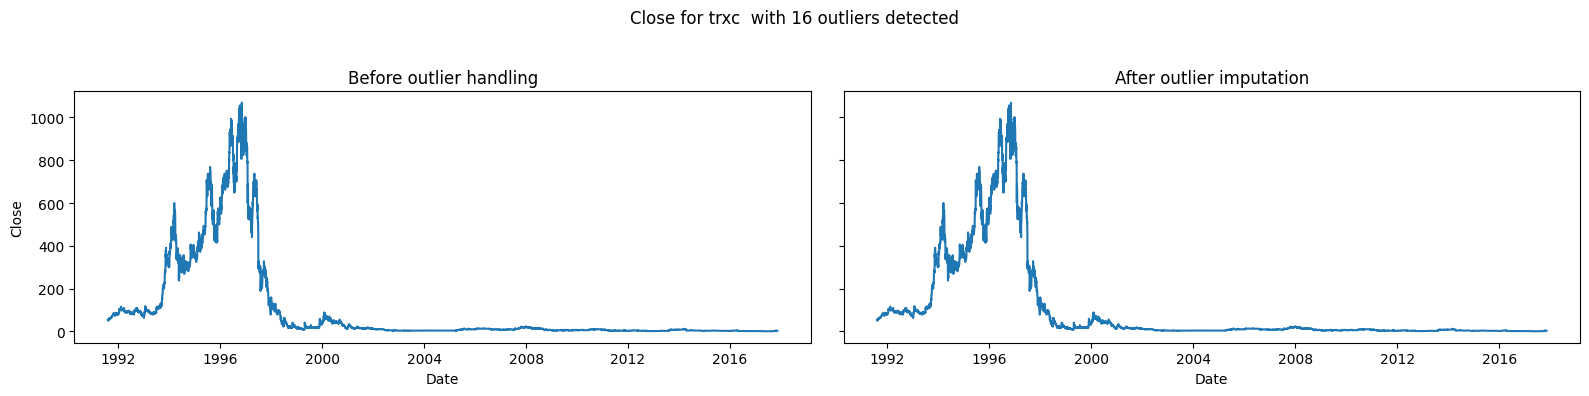

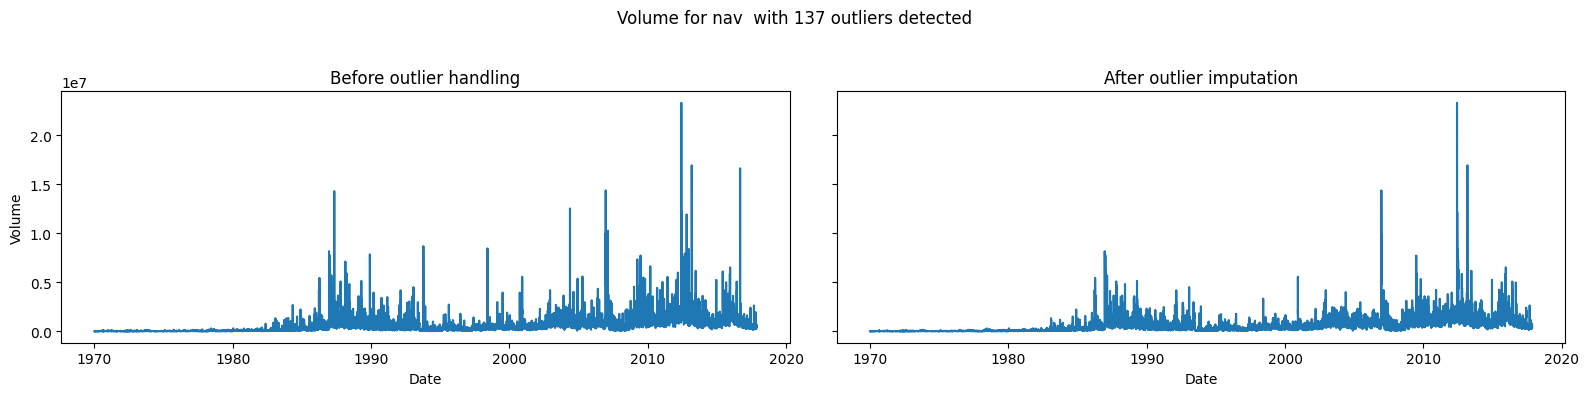

In [28]:
# Print unique companies with highest number of outliers per column
value_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

top_symbols = {}
used_symbols = set()

for col in value_cols:
    counts = (
        mask.groupby(df['Symbol'])[col]
        .sum()
        .sort_values(ascending=False)
    )

    chosen = None
    for sym in counts.index:        
        if sym not in used_symbols:
            chosen = sym
            used_symbols.add(sym)
            break

    top_symbols[col] = chosen

top_symbols

for col in value_cols:
    sym = top_symbols[col]
    if sym is None:
        continue

    # filter rows for this symbol
    d_orig = df[df['Symbol'] == sym].sort_values('Date')
    d_clean = df_clean[df_clean['Symbol'] == sym].sort_values('Date')

    # how many outliers did we detect for THIS symbol in THIS column?
    n_outliers = mask.loc[df['Symbol'] == sym, col].sum()

    # wider figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
    fig.suptitle(f"{col} for {sym}  with {n_outliers} outliers detected")

    # before
    axes[0].plot(d_orig['Date'], d_orig[col])
    axes[0].set_title("Before outlier handling")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel(col)

    # after
    axes[1].plot(d_clean['Date'], d_clean[col])
    axes[1].set_title("After outlier imputation")
    axes[1].set_xlabel("Date")

    # a bit more space between the two plots
    plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=2.0)
    plt.show()


In [29]:
# Initial summary for rows with outliers
rows_imputed = rows_flagged  

metrics_df = pd.DataFrame(
    {
        "Value": [
            len(df),                      
            rows_flagged,                 
            rows_imputed,                 
            rows_flagged / len(df) * 100  
        ]
    },
    index=[
        "Number of rows before cleaning",
        "Number of rows with outliers",
        "Imputed rows with outliers",
        "Percentage of rows with outliers",
    ],
)

metrics_df = metrics_df.reset_index().rename(columns={"index": "Measurement"})

idx = pd.IndexSlice

styled = (
    metrics_df.style
        .hide(axis="index")
        .format({"Value": "{:,.0f}"}, subset=idx[0:2, "Value"])
        .format({"Value": "{:,.0f}"}, subset=idx[2, "Value"])
        .format({"Value": "{:.2f}%"}, subset=idx[3, "Value"])
)

styled

Measurement,Value
Number of rows before cleaning,"15,259,882"
Number of rows with outliers,"184,512"
Imputed rows with outliers,"184,512"
Percentage of rows with outliers,1.21%


In [30]:
# Detailed summary for each column with outliers
value_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

flagged_counts = mask.sum()  
total_rows = len(df)

rows = []
for col in value_cols:
    flagged_n = int(flagged_counts[col])
    pct_flagged = flagged_n / total_rows * 100
    rows.append([
        col,
        total_rows,
        flagged_n,
        pct_flagged,
    ])

metrics_df = pd.DataFrame(
    rows,
    columns=[
        "Column",
        "Total rows (before imputation)",
        "Flagged cells (imputed)",
        "Share of flagged cells",
    ],
)

display(
    metrics_df.style
        .format({
            "Total rows (before imputation)": "{:,.0f}",
            "Flagged cells (imputed)": "{:,.0f}",
            "Share of flagged cells": "{:.2f}%",
        })
        .hide(axis="index")
)


Column,Total rows (before imputation),Flagged cells (imputed),Share of flagged cells
Open,"15,259,882","5,100",0.03%
High,"15,259,882","6,607",0.04%
Low,"15,259,882","6,277",0.04%
Close,"15,259,882","3,129",0.02%
Volume,"15,259,882","170,404",1.12%


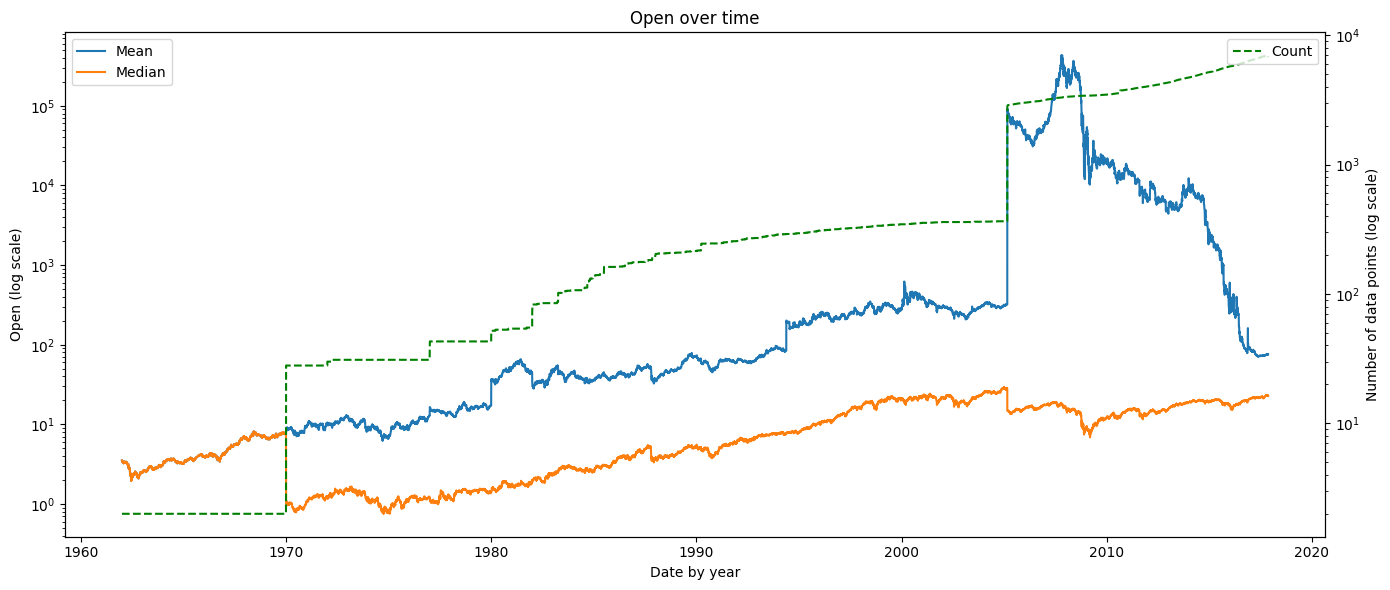

In [31]:
# Mean and median value for columns over time after outlier detection and forward-fill imputation
date_data = df_clean.groupby('Date')
dates = list(date_data.indices.keys())

columns = ['Open'] # ['Open','High', 'Low', 'Close', 'Volume']

for col in columns:
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(dates, date_data[col].mean(), label="Mean")
    ax1.plot(dates, date_data[col].median(), label="Median")
    ax1.set_xlabel('Date by year')
    ax1.set_ylabel(f'{col} (log scale)')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(dates, date_data[col].count(), label='Count', color='green',  linestyle='--')
    ax2.set_ylabel('Number of data points (log scale)')
    ax2.set_yscale("log")
    ax2.legend(loc='upper right')

    plt.title(f'{col} over time')
    plt.tight_layout()
    plt.show()

In [49]:
value_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_clean[value_cols].describe()

,Open,High,Low,Close,Volume
count,15259882.00,15259882.00,15259882.00,15259882.00,15259882.00
mean,29654.12,30461.19,28655.24,29517.39,1509335.26
std,4150959.72,4270459.28,3997348.37,4129317.16,7188560.22
min,0.00,0.00,0.00,0.00,0.00
25%,7.68,7.81,7.54,7.68,27246.00
50%,15.60,15.83,15.35,15.60,175462.50
75%,28.70,29.06,28.30,28.69,838970.75
max,1423712891.00,1442048636.45,1362117843.98,1437986240.44,2304018600.00


In [50]:
df = df_clean.copy()

b. Decide whether to remove, cap, or transform the outliers. Justify your decisions.

## 4. Data Transformation

a. Encoding Categorical Data

i. Apply label encoding or one-hot encoding to transform categorical data into
numerical form.

In [52]:
# Encode Symbol column with Label Encoding
df_encoded = df.copy() 
label_encoder = LabelEncoder()
df_encoded["Symbol"] = label_encoder.fit_transform(df_encoded["Symbol"])
value_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
df_encoded[value_cols].describe()

,Open,High,Low,Close,Volume,Symbol
count,15259882.00,15259882.00,15259882.00,15259882.00,15259882.00,15259882.00
mean,29654.12,30461.19,28655.24,29517.39,1509335.26,3544.61
std,4150959.72,4270459.28,3997348.37,4129317.16,7188560.22,2080.73
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.68,7.81,7.54,7.68,27246.00,1693.00
50%,15.60,15.83,15.35,15.60,175462.50,3576.00
75%,28.70,29.06,28.30,28.69,838970.75,5318.00
max,1423712891.00,1442048636.45,1362117843.98,1437986240.44,2304018600.00,7162.00


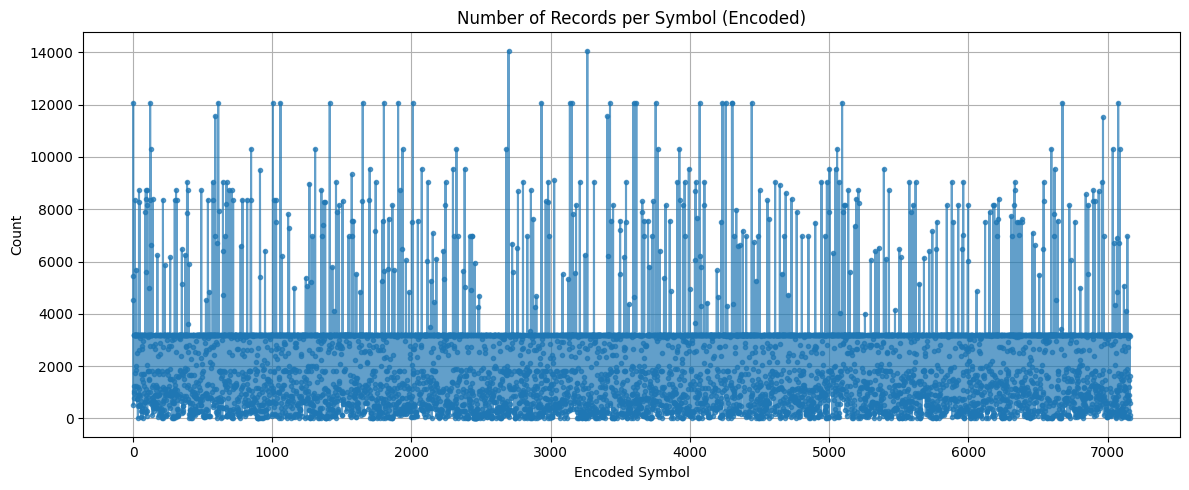

In [35]:
# Visualize distribution of encoded symbols
symbol_counts = df_encoded["Symbol"].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(symbol_counts.index, symbol_counts.values, marker='.', linestyle='-', alpha=0.7)
plt.title("Number of Records per Symbol (Encoded)")
plt.xlabel("Encoded Symbol")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


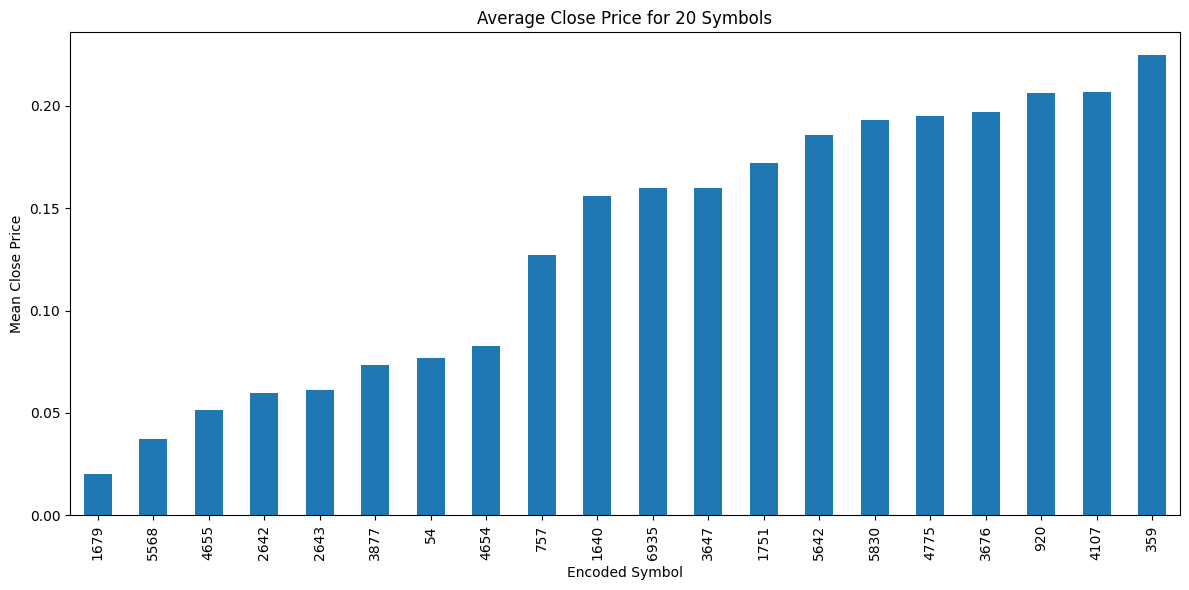

In [36]:
# Analyze relationship between encoded symbols and Close price
symbol_means = df_encoded.groupby("Symbol")["Close"].mean().sort_values().head(20)  # or tail(20)

plt.figure(figsize=(12, 6))
symbol_means.plot(kind="bar")
plt.title("Average Close Price for 20 Symbols")
plt.xlabel("Encoded Symbol")
plt.ylabel("Mean Close Price")
plt.tight_layout()
plt.show()

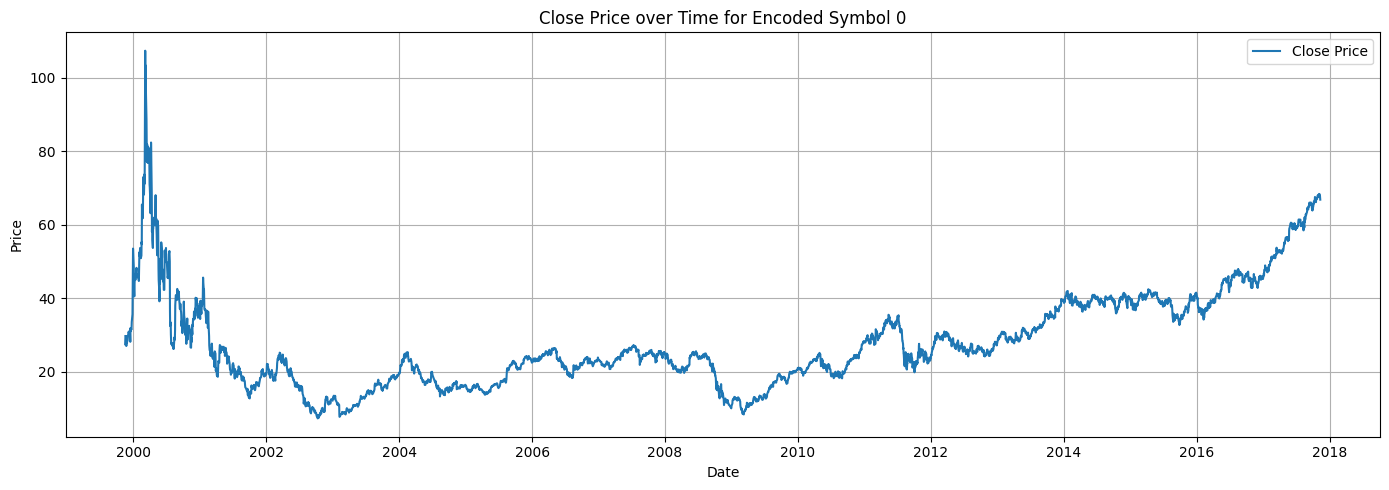

In [37]:
# Visualize Close price over time for a specific encoded symbol (e.g., symbol 0)
symbol_0_data = df_encoded[df_encoded["Symbol"] == 0]

plt.figure(figsize=(14, 5))
plt.plot(symbol_0_data["Date"], symbol_0_data["Close"], label="Close Price")
plt.title("Close Price over Time for Encoded Symbol 0")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
df = df_encoded.copy()

ii. Justify your choice of encoding method

b. Feature Scaling

i. Apply feature scaling techniques such as normalization (Min-Max scaling) or standardization (Z-score normalization) to the dataset.

In [39]:
print(df[value_cols].min())
print(df[value_cols].max())

Open     0.00
High     0.00
Low      0.00
Close    0.00
Volume   0.00
dtype: float64
Open     1423712891.00
High     1442048636.45
Low      1362117843.98
Close    1437986240.44
Volume   2304018600.00
dtype: float64
Open     1423712891.00
High     1442048636.45
Low      1362117843.98
Close    1437986240.44
Volume   2304018600.00
dtype: float64


In [40]:
df[value_cols].describe()

,Open,High,Low,Close,Volume
count,15259882.00,15259882.00,15259882.00,15259882.00,15259882.00
mean,29654.12,30461.19,28655.24,29517.39,1509335.26
std,4150959.72,4270459.28,3997348.37,4129317.16,7188560.22
min,0.00,0.00,0.00,0.00,0.00
25%,7.68,7.81,7.54,7.68,27246.00
50%,15.60,15.83,15.35,15.60,175462.50
75%,28.70,29.06,28.30,28.69,838970.75
max,1423712891.00,1442048636.45,1362117843.98,1437986240.44,2304018600.00


In [41]:
# Scale Open, High, Low, Close, Volume columns with Min-Max Scaling
df_scaled = df.copy()

for col in value_cols:
    df_scaled[col] = df.groupby("Symbol")[col].transform(
        lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
    )
df_scaled[value_cols].describe()


,Open,High,Low,Close,Volume
count,15259882.00,15259882.00,15259882.00,15259882.00,15259882.00
mean,0.36,0.36,0.37,0.36,0.08
std,0.26,0.26,0.26,0.26,0.09
min,0.00,0.00,0.00,0.00,0.00
25%,0.14,0.14,0.14,0.14,0.02
50%,0.32,0.31,0.33,0.32,0.05
75%,0.56,0.55,0.56,0.56,0.10
max,1.00,1.00,1.00,1.00,1.00


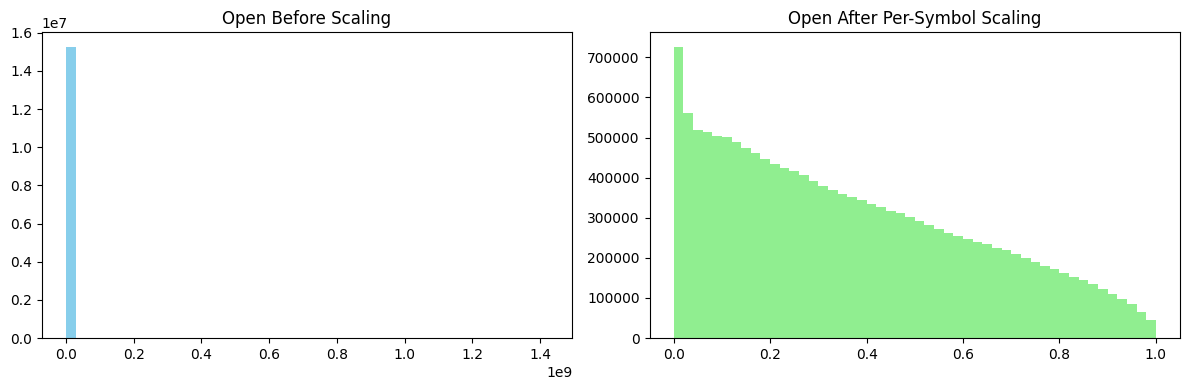

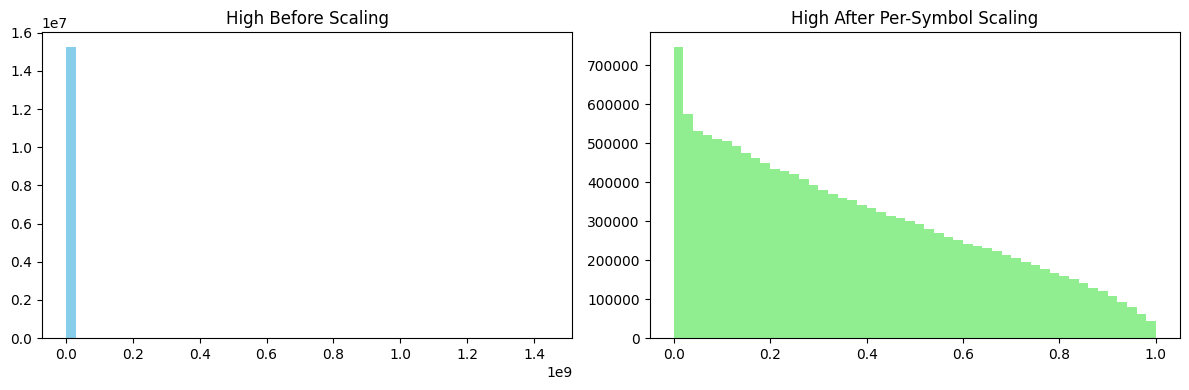

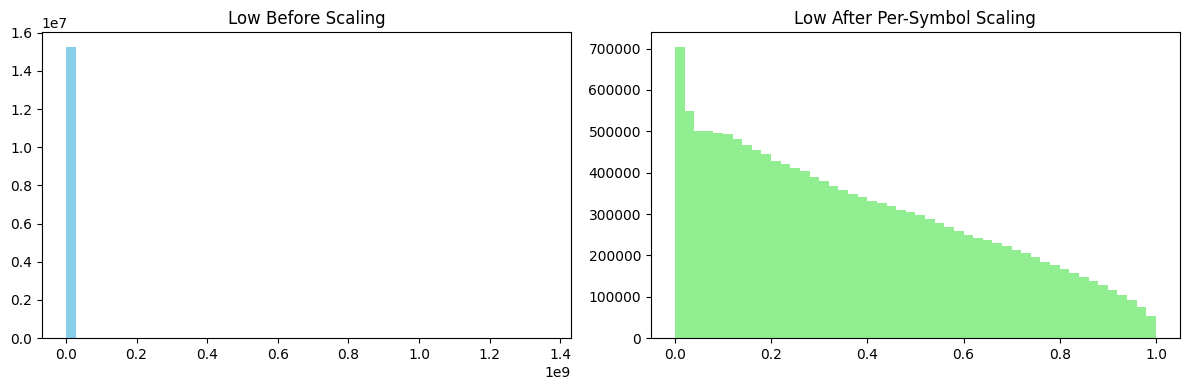

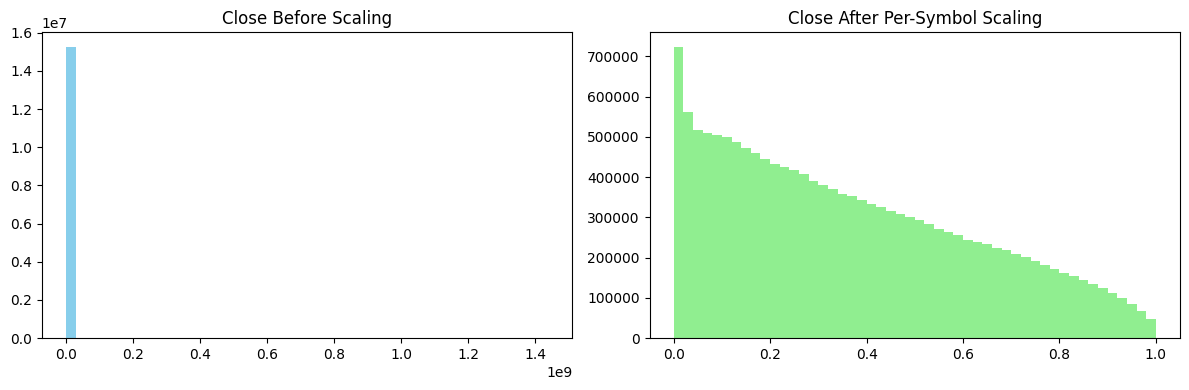

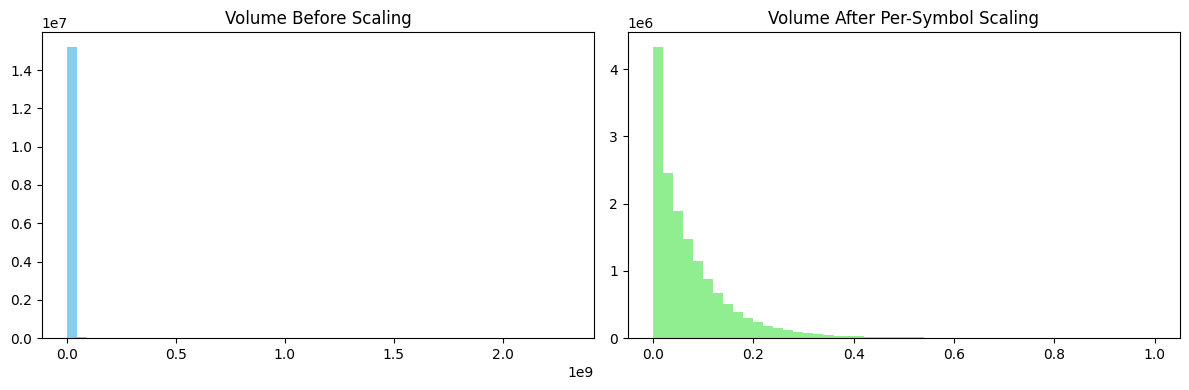

In [42]:
# Visualize distributions before and after scaling
for col in value_cols:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].hist(df[col].dropna(), bins=50, color='skyblue')
    axs[0].set_title(f'{col} Before Scaling')

    axs[1].hist(df_scaled[col].dropna(), bins=50, color='lightgreen')
    axs[1].set_title(f'{col} After Per-Symbol Scaling')

    plt.tight_layout()
    plt.show()

In [43]:
df = df_scaled.copy()

ii. Explain why feature scaling is necessary and how it impacts the model.

## 5. Data Splitting

a. Split the preprocessed dataset into training and testing sets. Typically, an 80-20 or 70-30 split is used.

In [44]:
# Split dataset into training (80%) and testing (20%) sets based on chronological order per symbol
df_train_list = []
df_test_list = []

for sym, group in df.groupby("Symbol"):
    group = group.sort_values("Date")
    split_idx = int(len(group) * 0.8)
    df_train_list.append(group.iloc[:split_idx])
    df_test_list.append(group.iloc[split_idx:])

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)

print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)


Training set shape: (12204550, 8)
Testing set shape: (3055332, 8)


b. Explain the importance of splitting the data and how it prevents overfitting.

## 6. Apply dimensionality reduction techniques such as Principal Component Analysis (PCA) and discuss how it affects the dataset.

In [45]:
# PCA analysis on training set
value_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

X_train = df_train[value_cols]
X_test = df_test[value_cols]

pca_full = PCA(n_components=len(value_cols))
pca_full.fit(X_train)

expl_var = pca_full.explained_variance_ratio_  

rows = []
for i, v in enumerate(expl_var, start=1):
    rows.append([
        f"PC{i}",
        v,            
        v * 100,      
    ])

pca_var_df = pd.DataFrame(
    rows,
    columns=[
        "Component",
        "Explained variance ratio",
        "Share of variance",
    ],
)

display(
    pca_var_df.style
        .format({
            "Explained variance ratio": "{:.4f}",
            "Share of variance": "{:.2f}%",
        })
        .hide(axis="index")
)

# Project training and testing data onto first two principal components
X_train_pca = pca_full.transform(X_train)[:, :2]
X_test_pca = pca_full.transform(X_test)[:, :2]

df_pca_train = pd.concat(
    [df_train[['Date', 'Symbol']].reset_index(drop=True),
     pd.DataFrame(X_train_pca, columns=['PC1','PC2'])],
    axis=1
)
df_pca_test = pd.concat(
    [df_test[['Date', 'Symbol']].reset_index(drop=True),
     pd.DataFrame(X_test_pca, columns=['PC1','PC2'])],
    axis=1
)

display(df_pca_train.head())
display(df_pca_test.head())


Component,Explained variance ratio,Share of variance
PC1,0.9609,96.09%
PC2,0.0353,3.53%
PC3,0.0021,0.21%
PC4,0.0012,0.12%
PC5,0.0004,0.04%


,Date,Symbol,PC1,PC2
0,1999-11-18,0,-0.17,0.93
1,1999-11-19,0,-0.23,0.17
2,1999-11-22,0,-0.22,0.03
3,1999-11-23,0,-0.23,0.02
4,1999-11-24,0,-0.24,0.01


,Date,Symbol,PC1,PC2
0,2014-04-11,0,-0.05,-0.02
1,2014-04-14,0,-0.05,-0.01
2,2014-04-15,0,-0.05,-0.03
3,2014-04-16,0,-0.04,-0.05
4,2014-04-17,0,-0.03,-0.03


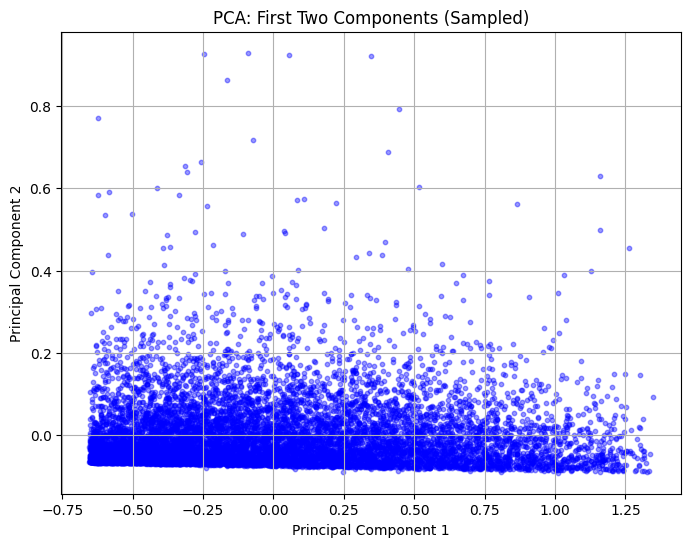

In [46]:
# Visualize the first two principal components for a sample of the training set
sample_df = df_pca_train.sample(n=10000, random_state=42)  
plt.figure(figsize=(8,6))
plt.scatter(sample_df['PC1'], sample_df['PC2'], alpha=0.4, s=10, color='blue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Components (Sampled)')
plt.grid(True)
plt.show()

In [47]:
# Plot explained variance and cumulative explained variance
components = np.arange(1, len(value_cols) + 1)

plt.figure(figsize=(8, 5))

# cumulative explained variance (blue line)
plt.plot(components, cum_expl_var, label='Cumulative Variance',
         marker='o')

# explained variance per component (orange line)
plt.plot(components, expl_var, label='Variance for each Component',
         marker='o')

# 90% threshold
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Threshold')

plt.xticks(components)
plt.ylim(0, 1.05)
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'cum_expl_var' is not defined

<Figure size 800x500 with 0 Axes>